# TMDB Movie Analysis Pipeline - PySpark Version

This notebook demonstrates the complete data pipeline for analyzing TMDB movie data using Apache Spark.

**Pipeline Steps:**
1. Setup and configuration
2. Data Fetching and cleaning and preprocessing
3. Exploratory Data Analysis
4. KPI analysis
5. Advanced filtering
6. Aggregation analysis
7. Visualizations

**Requirements:**
- Running Docker container with Jupyter/Spark
- TMDB API credentials in `.env` file
- Raw movie data in `data/raw/` directory

## 1. Setup and Imports

Initialize SparkSession and import necessary modules.

In [1]:
# Add project root to Python path
import sys
from pathlib import Path

project_root = Path('/home/jovyan/work')
sys.path.insert(0, str(project_root))

print(f"Project root: {project_root}")
print(f"Python path: {sys.path[:2]}")

Project root: /home/jovyan/work
Python path: ['/home/jovyan/work', '/usr/local/spark/python/lib/py4j-0.10.9.9-src.zip']


In [2]:
# Core imports
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Project imports
from src.utils.spark_utils import get_spark_session, stop_spark_session
from src.utils.helpers import load_config, setup_logging

# Configure logging
logger = setup_logging(module_name='notebook')
logger.info("Notebook initialized")

2026-01-29 10:45:19 - notebook - INFO - Notebook initialized


In [3]:
# Initialize SparkSession
spark = get_spark_session(app_name="TMDB_Analysis_Pipeline")

print("="*60)
print(f"Spark Version: {spark.version}")
print(f"Spark Master: {spark.sparkContext.master}")
print(f"App Name: {spark.sparkContext.appName}")
print(f"Spark UI: http://localhost:4040")
print("="*60)

Spark Version: 4.1.0
Spark Master: local[*]
App Name: TMDB_Analysis
Spark UI: http://localhost:4040


## 2. Configuration

Load project configuration and verify paths.

In [4]:
# Load configuration
# config = load_config('config/config.yaml')
config = load_config(str(project_root / 'config/config.yaml'))

print("Configuration loaded:")
print(f"  Raw data path: {config['paths']['raw_data']}")
print(f"  Processed data path: {config['paths']['processed_data']}")
print(f"  Spark master: {config['spark']['master']}")
print(f"  Spark app name: {config['spark']['app.name']}")

Configuration loaded:
  Raw data path: data/raw/
  Processed data path: data/processed/
  Spark master: local[*]
  Spark app name: TMDB_Analysis


## 2.1 Testing Pipeline

In [5]:
!python -m pytest ./tests -v
# !python -m pytest ./tests/test_utils.py -v
# !python -m pytest ./tests/test_fetch.py -v
# !python -m pytest ./tests/test_cleaning.py -v
# !python -m pytest ./tests/test_analytics.py -v

============================= test session starts ==============================
platform linux -- Python 3.13.11, pytest-9.0.2, pluggy-1.6.0 -- /opt/conda/bin/python
cachedir: .pytest_cache
rootdir: /home/jovyan/work
plugins: mock-3.15.1, cov-7.0.0, anyio-4.12.0
collected 18 items                                                             

tests/test_analytics.py::TestKPICalculator::test_rank_movies_revenue PASSED [  5%]
tests/test_analytics.py::TestKPICalculator::test_get_top_by_roi PASSED   [ 11%]
tests/test_analytics.py::TestKPICalculator::test_get_top_rated_filter PASSED [ 16%]
tests/test_analytics.py::TestAggregations::test_compare_franchise_vs_standalone PASSED [ 22%]
tests/test_analytics.py::TestAggregations::test_get_top_franchises PASSED [ 27%]
tests/test_analytics.py::TestAggregations::test_get_top_directors PASSED [ 33%]
tests/test_cleaning.py::TestCleaner::test_drop_irrelevant_columns PASSED [ 38%]
tests/test_cleaning.py::TestCleaner::test_flatten_nested_columns PASSED  

## 3. Data Fetching

**Note:** This step is optional if you already have raw data in `data/raw/`.

The data fetching module works the same in both Pandas and Spark versions since it only writes JSON files.

In [6]:
# Fetch data using absolute paths
from src.fetch.fetch_tmdb_api import TMDBFetcher

# Use absolute path for config file
config_path = str(project_root / 'config' / 'config.yaml')
fetcher = TMDBFetcher(config_path=config_path)

# Example: Fetch specific movies
movie_ids = [0, 299534, 19995, 140607, 299536, 597, 135397, 420818, 24428, 
             168259, 99861, 284054, 12445, 181808, 330457, 351286, 109445, 
             321612, 260513]

print(f"Fetching {len(movie_ids)} movies...")
count = fetcher.fetch_movies(movie_ids, skip_existing=True)
print(f"Successfully fetched {count} new movies")
print(f"Data saved to: {fetcher.raw_data_path}")

Fetching 19 movies...


Fetching movies:   0%|          | 0/19 [00:00<?, ?it/s]

2026-01-29 10:45:55 - fetch - ERROR - Error fetching movie 0: 404 Client Error: Not Found for url: https://api.themoviedb.org/3/movie/0?api_key=b52da0c30e5cff65bed4b8dbda2060d5&append_to_response=credits%2Ckeywords


Fetching movies: 100%|██████████| 19/19 [00:00<00:00, 27.61it/s]

Successfully fetched 0 new movies
Data saved to: data/raw


## 4. Verify Raw Data

Check what raw data files are available.

In [7]:
from pathlib import Path

raw_data_path = Path('data/raw')
json_files = list(raw_data_path.glob('*.json'))

print(f"Found {len(json_files)} JSON files in {raw_data_path}")
if json_files:
    print("\nFirst 5 files:")
    for f in json_files[:5]:
        print(f"  - {f.name}")

Found 18 JSON files in data/raw

First 5 files:
  - 109445.json
  - 12445.json
  - 135397.json
  - 140607.json
  - 168259.json


## 6. Load Multiple JSON Files

Test loading multiple JSON files at once using Spark.

In [8]:
# Load all JSON files from raw data directory
if json_files:
    raw_df = spark.read.option('multiLine','true').json(str(raw_data_path / '*.json'))
    
    print(f"Loaded {raw_df.count()} movies")
    print(f"Columns: {len(raw_df.columns)}")
    
    # Show basic info
    raw_df.select('id', 'title', 'release_date', 'budget', 'revenue', 'vote_average').show(10)
    
    # Cache for future operations
    raw_df.cache()
    print("\nDataFrame cached in memory")
else:
    print("No data to load. Please fetch data first.")

Loaded 18 movies
Columns: 28
+------+--------------------+------------+---------+----------+------------+
|    id|               title|release_date|   budget|   revenue|vote_average|
+------+--------------------+------------+---------+----------+------------+
| 19995|              Avatar|  2009-12-16|237000000|2923706026|         7.6|
|299536|Avengers: Infinit...|  2018-04-25|300000000|2052415039|       8.234|
| 24428|        The Avengers|  2012-04-25|220000000|1518815515|       7.923|
| 99861|Avengers: Age of ...|  2015-04-22|235000000|1405403694|       7.271|
|299534|   Avengers: Endgame|  2019-04-24|356000000|2799439100|       8.236|
|284054|       Black Panther|  2018-02-13|200000000|1349926083|       7.363|
|135397|      Jurassic World|  2015-06-06|150000000|1671537444|       6.699|
|140607|Star Wars: The Fo...|  2015-12-15|245000000|2068223624|       7.252|
|351286|Jurassic World: F...|  2018-06-06|170000000|1310469037|       6.534|
|   597|             Titanic|  1997-12-18|20000

## 7 Data cleaning and preprocessing with Spark

In [9]:
from src.cleaning.cleaner import SparkMovieDataCleaner

# Initialize cleaner
cleaner = SparkMovieDataCleaner(spark=spark)

# Run cleaning pipeline on raw data
cleaned_df = cleaner.clean_all(raw_df)

# Show results
print(f"Cleaned movies: {cleaned_df.count()}")
cleaned_df.show(1)
cleaned_df.printSchema()

Cleaned movies: 18
+---+-------+--------------------+------------+-------------+---------------+-----------------+-----------+------------+--------------------+--------------------+----------+------------+----------+-------+--------------------+--------------------+--------------------+---------+-------------+---------+------------+--------------------+
| id|  title|             tagline|release_date|       genres|collection_name|original_language|budget_musd|revenue_musd|production_companies|production_countries|vote_count|vote_average|popularity|runtime|            overview|    spoken_languages|                cast|cast_size|     director|crew_size|release_year|            keywords|
+---+-------+--------------------+------------+-------------+---------------+-----------------+-----------+------------+--------------------+--------------------+----------+------------+----------+-------+--------------------+--------------------+--------------------+---------+-------------+---------+-----

## EXPLORATORY DATA ANALYSIS (EDA)

EXPLORATORY DATA ANALYSIS
1. DATASET OVERVIEW

Dataset Shape:
  Number of rows: 18
  Number of columns: 23

Column Names:
   1. id
   2. title
   3. tagline
   4. release_date
   5. genres
   6. collection_name
   7. original_language
   8. budget_musd
   9. revenue_musd
  10. production_companies
  11. production_countries
  12. vote_count
  13. vote_average
  14. popularity
  15. runtime
  16. overview
  17. spoken_languages
  18. cast
  19. cast_size
  20. director
  21. crew_size
  22. release_year
  23. keywords

2. MISSING VALUE ANALYSIS

Missing Values by Column (sorted by percentage):
+--------------------+----------+---------------+
|column              |null_count|null_percentage|
+--------------------+----------+---------------+
|collection_name     |2         |11.11          |
|vote_average        |0         |0.0            |
|original_language   |0         |0.0            |
|popularity          |0         |0.0            |
|crew_size           |0         |0.0            |


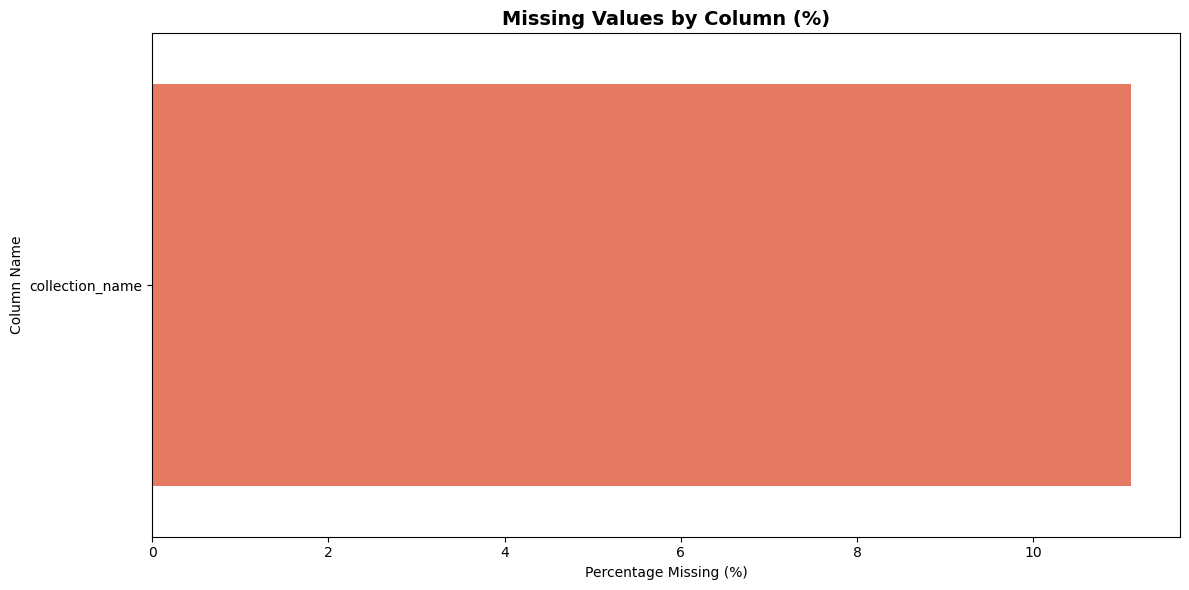


3. STATISTICAL SUMMARY OF NUMERICAL COLUMNS

Descriptive Statistics:
+-------+------------------+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+
|summary|       budget_musd|     revenue_musd|           runtime|      vote_average|       vote_count|        popularity|         cast_size|         crew_size|
+-------+------------------+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+
|  count|                18|               18|                18|                18|               18|                18|                18|                18|
|   mean|213.77777777777777|1691.831827722222|138.05555555555554|7.3931111111111125|20637.11111111111| 19.66146666666667| 84.44444444444444| 384.3888888888889|
| stddev|61.959717042185666|521.0622853292365|23.848719837938827|0.5132251986946506|7933.674980285646|14.516319699525207|39.388296

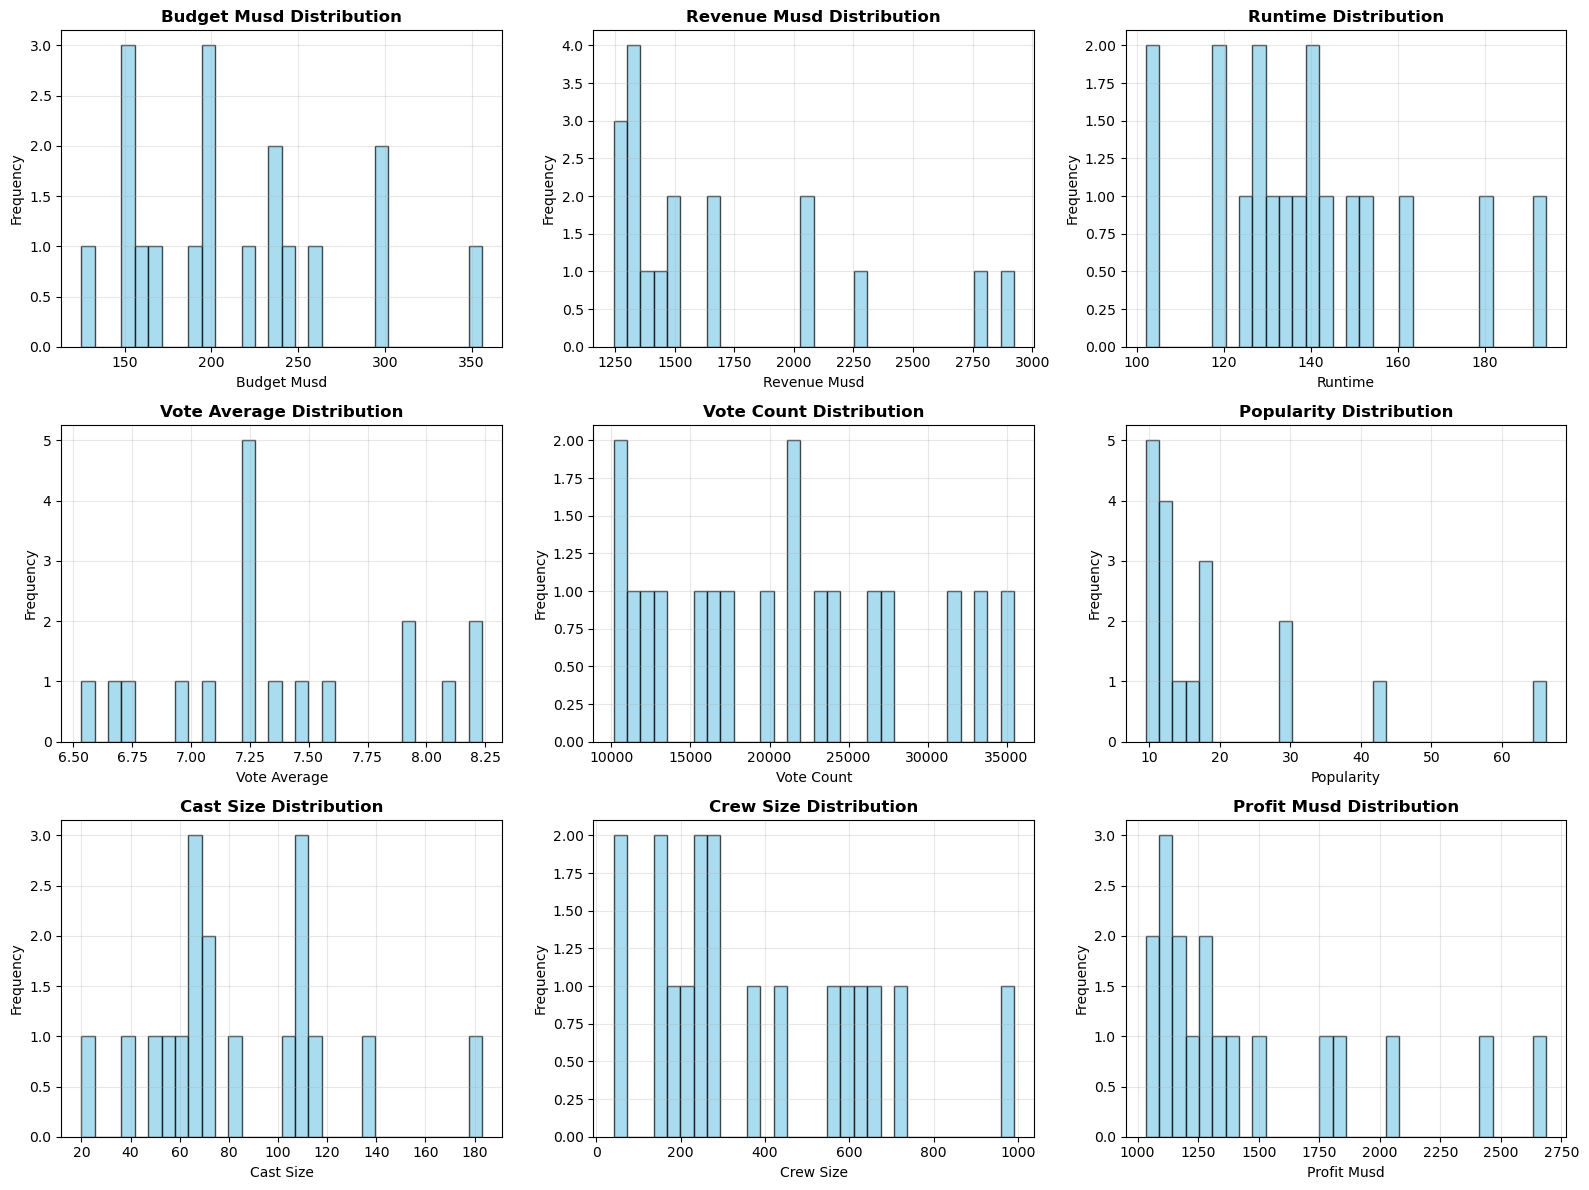


5. CATEGORICAL DATA ANALYSIS

5.1 Top 15 Genres (by movie count):
+---------------+-----+
|genre          |count|
+---------------+-----+
|Adventure      |15   |
|Action         |12   |
|Science Fiction|10   |
|Family         |5    |
|Fantasy        |5    |
|Animation      |4    |
|Thriller       |3    |
|Romance        |2    |
|Drama          |2    |
|Crime          |1    |
|Comedy         |1    |
+---------------+-----+



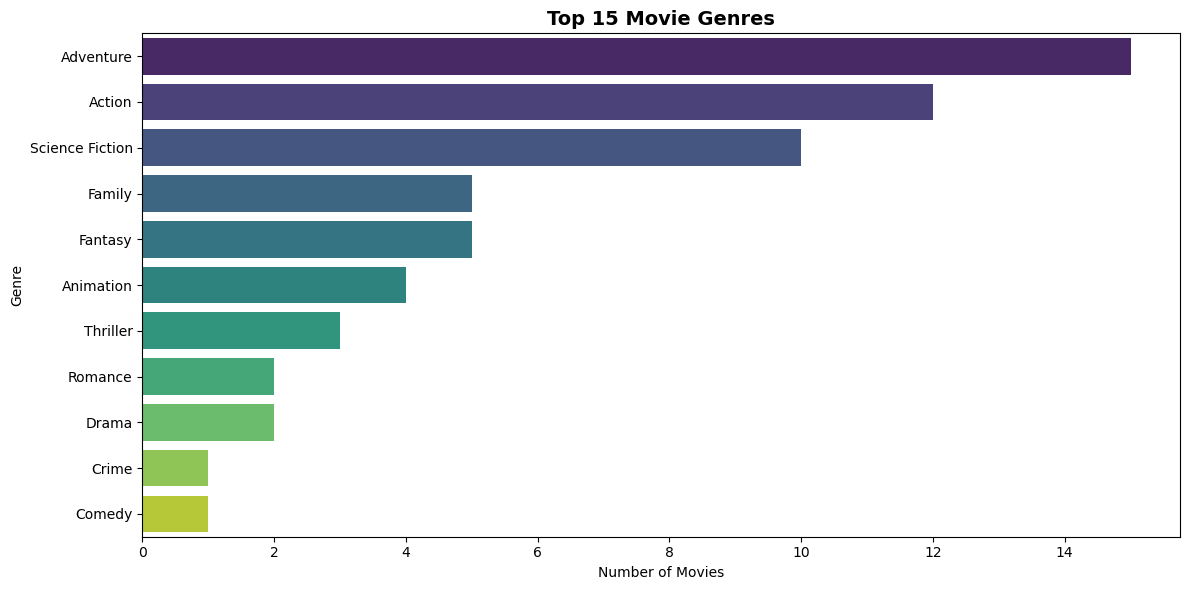


EDA COMPLETE


In [10]:
# ================================================================================
# EXPLORATORY DATA ANALYSIS (EDA)
# ================================================================================

from src.analytics import SparkEDA

# Initialize EDA analyzer
eda = SparkEDA(spark=spark)

# Run complete EDA pipeline
eda.run_full_eda(cleaned_df)

# OR run individual analyses as needed:
# eda.dataset_overview(cleaned_df)
# eda.missing_value_analysis(cleaned_df)
# eda.statistical_summary(cleaned_df)
# eda.plot_distributions(cleaned_df)
# eda.categorical_analysis(cleaned_df)
# eda.temporal_analysis(cleaned_df)
# eda.correlation_analysis(cleaned_df)

## 8 KPI calculations (revenue, ROI, ratings)

In [11]:
from src.analytics.kpi_calculator import SparkKPICalculator

# Initialize calculator
kpi = SparkKPICalculator(spark=spark)

print("="*80)
print("KPI ANALYSIS - BEST/WORST PERFORMING MOVIES")
print("="*80)

# 1. Highest Revenue
print("\n1. HIGHEST REVENUE MOVIES")
print("-" * 80)
kpi.get_top_by_revenue(cleaned_df, top_n=10).show(10, truncate=False)

# 2. Highest Budget
print("\n2. HIGHEST BUDGET MOVIES")
print("-" * 80)
kpi.get_top_by_budget(cleaned_df, top_n=10).show(10, truncate=False)

# 3. Highest Profit (Revenue - Budget)
print("\n3. HIGHEST PROFIT MOVIES (Revenue - Budget)")
print("-" * 80)
kpi.get_top_by_profit(cleaned_df, top_n=10).show(10, truncate=False)

# 4. Lowest Profit (Revenue - Budget)
print("\n4. LOWEST PROFIT MOVIES (Biggest Losses)")
print("-" * 80)
kpi.get_bottom_by_profit(cleaned_df, top_n=10).show(10, truncate=False)

# 5. Highest ROI (Budget >= $10M)
print("\n5. HIGHEST ROI MOVIES (Budget >= $10M)")
print("-" * 80)
kpi.get_top_by_roi(cleaned_df, top_n=10).show(10, truncate=False)

# 6. Lowest ROI (Budget >= $10M)
print("\n6. LOWEST ROI MOVIES (Budget >= $10M)")
print("-" * 80)
kpi.get_bottom_by_roi(cleaned_df, top_n=10).show(10, truncate=False)

# 7. Most Voted Movies
print("\n7. MOST VOTED MOVIES")
print("-" * 80)
kpi.get_most_voted(cleaned_df, top_n=10).show(10, truncate=False)

# 8. Highest Rated Movies (vote_count >= 10)
print("\n8. HIGHEST RATED MOVIES (Minimum 10 votes)")
print("-" * 80)
kpi.get_top_rated(cleaned_df, top_n=10).show(10, truncate=False)

# 9. Lowest Rated Movies (vote_count >= 10)
print("\n9. LOWEST RATED MOVIES (Minimum 10 votes)")
print("-" * 80)
kpi.get_bottom_rated(cleaned_df, top_n=10).show(10, truncate=False)

# 10. Most Popular Movies
print("\n10. MOST POPULAR MOVIES")
print("-" * 80)
kpi.get_most_popular(cleaned_df, top_n=10).show(10, truncate=False)

print("\n" + "="*80)
print("KPI Analysis Complete!")
print("="*80)

KPI ANALYSIS - BEST/WORST PERFORMING MOVIES

1. HIGHEST REVENUE MOVIES
--------------------------------------------------------------------------------
+----+----------------------------+------------+------------+-----------+
|rank|title                       |revenue_musd|release_year|budget_musd|
+----+----------------------------+------------+------------+-----------+
|1   |Avatar                      |2923.706026 |2009        |237.0      |
|2   |Avengers: Endgame           |2799.4391   |2019        |356.0      |
|3   |Titanic                     |2264.162353 |1997        |200.0      |
|4   |Star Wars: The Force Awakens|2068.223624 |2015        |245.0      |
|5   |Avengers: Infinity War      |2052.415039 |2018        |300.0      |
|6   |Jurassic World              |1671.537444 |2015        |150.0      |
|7   |The Lion King               |1662.020819 |2019        |260.0      |
|8   |The Avengers                |1518.815515 |2012        |220.0      |
|9   |Furious 7                   

## 9 Filtering 

In [12]:
from src.analytics.filters import SparkMovieFilters
from src.analytics.aggregations import SparkMovieAggregations

# Initialize
filters = SparkMovieFilters(spark=spark)
agg = SparkMovieAggregations(spark=spark)

print("="*80)
print("ADVANCED MOVIE FILTERING & SEARCH QUERIES")
print("="*80)

# Search 1: Best-rated Sci-Fi Action movies with Bruce Willis
print("\n1. BEST-RATED SCIENCE FICTION ACTION MOVIES STARRING BRUCE WILLIS")
print("-" * 80)
print("   (Sorted by Rating - highest to lowest)")
result1 = filters.search_scifi_action_bruce_willis(cleaned_df)
if result1.count() > 0:
    result1.show(truncate=False)
else:
    print("   No results found.")

# Search 2: Uma Thurman + Quentin Tarantino collaborations
print("\n2. MOVIES STARRING UMA THURMAN, DIRECTED BY QUENTIN TARANTINO")
print("-" * 80)
print("   (Sorted by Runtime - shortest to longest)")
result2 = filters.search_uma_tarantino(cleaned_df)
if result2.count() > 0:
    result2.show(truncate=False)
else:
    print("   No results found.")

print("\n" + "="*80)
print("FRANCHISE VS. STANDALONE MOVIE PERFORMANCE")
print("="*80)

# Compare franchise vs standalone movies
print("\n3. FRANCHISE VS. STANDALONE COMPARISON")
print("-" * 80)
comparison = agg.compare_franchise_vs_standalone(cleaned_df)
comparison.show(truncate=False)

print("\n" + "="*80)
print("MOST SUCCESSFUL FRANCHISES")
print("="*80)

# Top franchises by total revenue
print("\n4. TOP 10 FRANCHISES BY TOTAL REVENUE")
print("-" * 80)
top_franchises = agg.get_top_franchises(cleaned_df, top_n=10, sort_by='total_revenue_musd')
top_franchises.show(10, truncate=False)

# Top franchises by mean rating
print("\n   TOP 10 FRANCHISES BY MEAN RATING")
print("-" * 80)
top_franchises_rating = agg.get_top_franchises(cleaned_df, top_n=10, sort_by='mean_rating')
top_franchises_rating.show(10, truncate=False)

print("\n" + "="*80)
print("MOST SUCCESSFUL DIRECTORS")
print("="*80)

# Top directors by total revenue
print("\n5. TOP 10 DIRECTORS BY TOTAL REVENUE")
print("-" * 80)
top_directors = agg.get_top_directors(cleaned_df, top_n=10, sort_by='total_revenue_musd', min_movies=1)
top_directors.show(10, truncate=False)

# Top directors by mean rating
print("\n   TOP 10 DIRECTORS BY MEAN RATING (Minimum 1 movie)")
print("-" * 80)
top_directors_rating = agg.get_top_directors(cleaned_df, top_n=10, sort_by='mean_rating', min_movies=1)
top_directors_rating.show(10, truncate=False)

print("\n" + "="*80)
print("Analysis Complete!")
print("="*80)


ADVANCED MOVIE FILTERING & SEARCH QUERIES

1. BEST-RATED SCIENCE FICTION ACTION MOVIES STARRING BRUCE WILLIS
--------------------------------------------------------------------------------
   (Sorted by Rating - highest to lowest)
   No results found.

2. MOVIES STARRING UMA THURMAN, DIRECTED BY QUENTIN TARANTINO
--------------------------------------------------------------------------------
   (Sorted by Runtime - shortest to longest)
   No results found.

FRANCHISE VS. STANDALONE MOVIE PERFORMANCE

3. FRANCHISE VS. STANDALONE COMPARISON
--------------------------------------------------------------------------------
+------------+-----------+------------------+-----------------+----------------+---------------+------------------+
|is_franchise|movie_count|mean_revenue_musd |median_roi       |mean_budget_musd|mean_popularity|mean_rating       |
+------------+-----------+------------------+-----------------+----------------+---------------+------------------+
|Standalone  |2         

## Data Visualization

DATA VISUALIZATIONS

1. Creating Revenue vs Budget Trends plot...


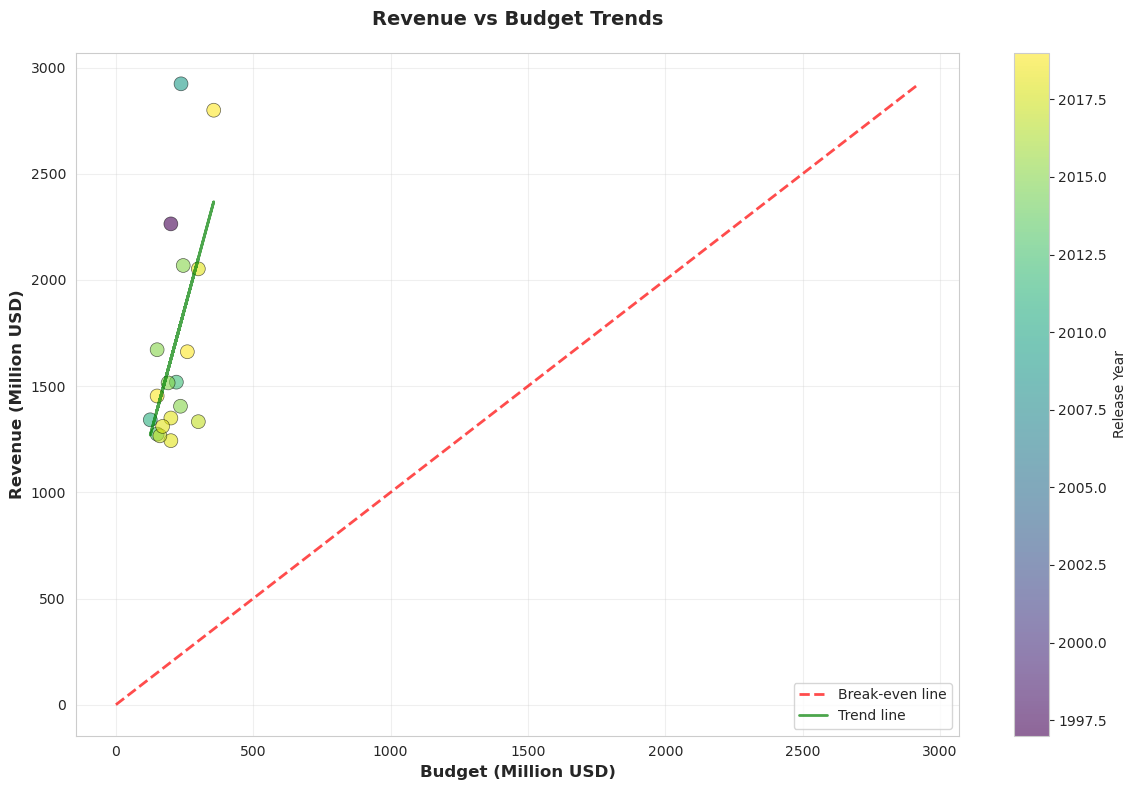


2. Creating ROI Distribution by Genre plot...


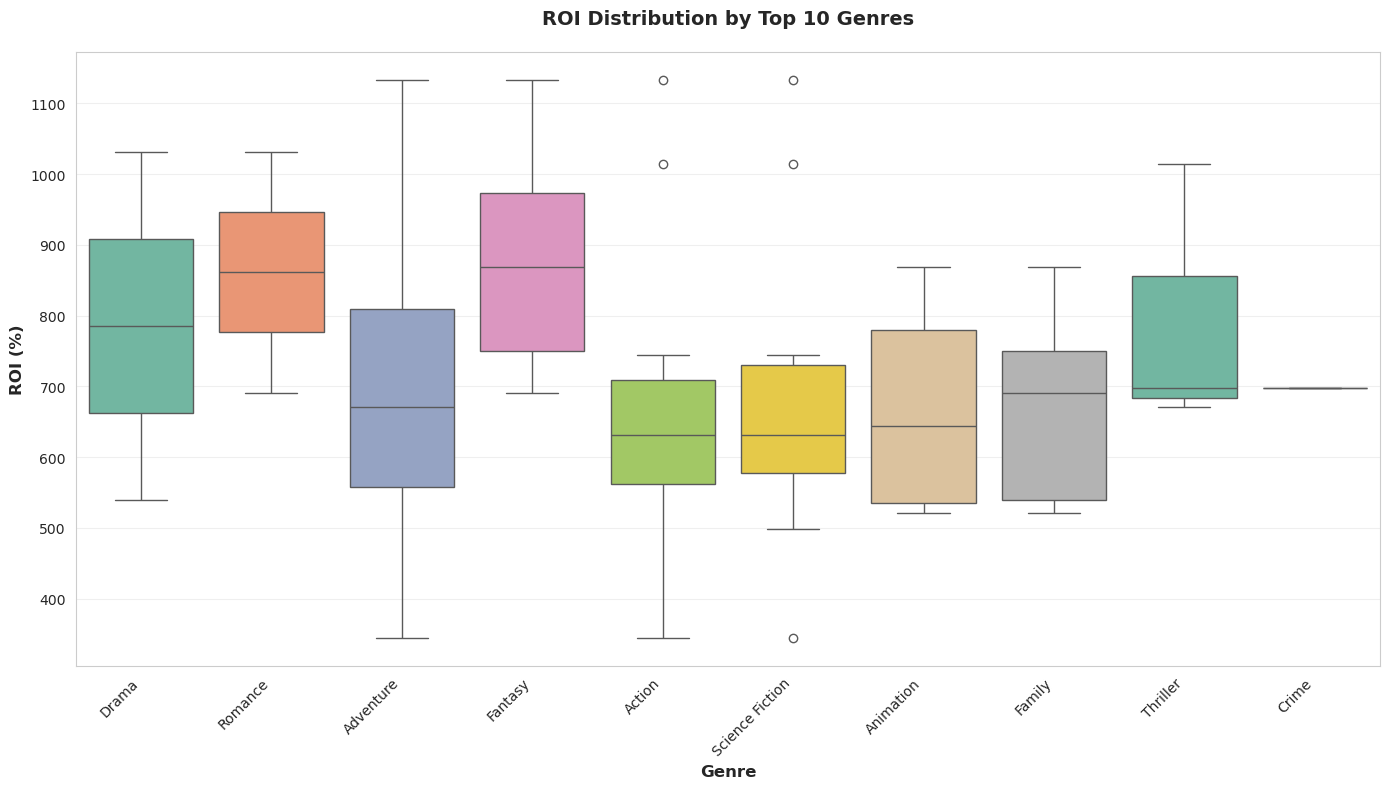


3. Creating Popularity vs Rating plot...


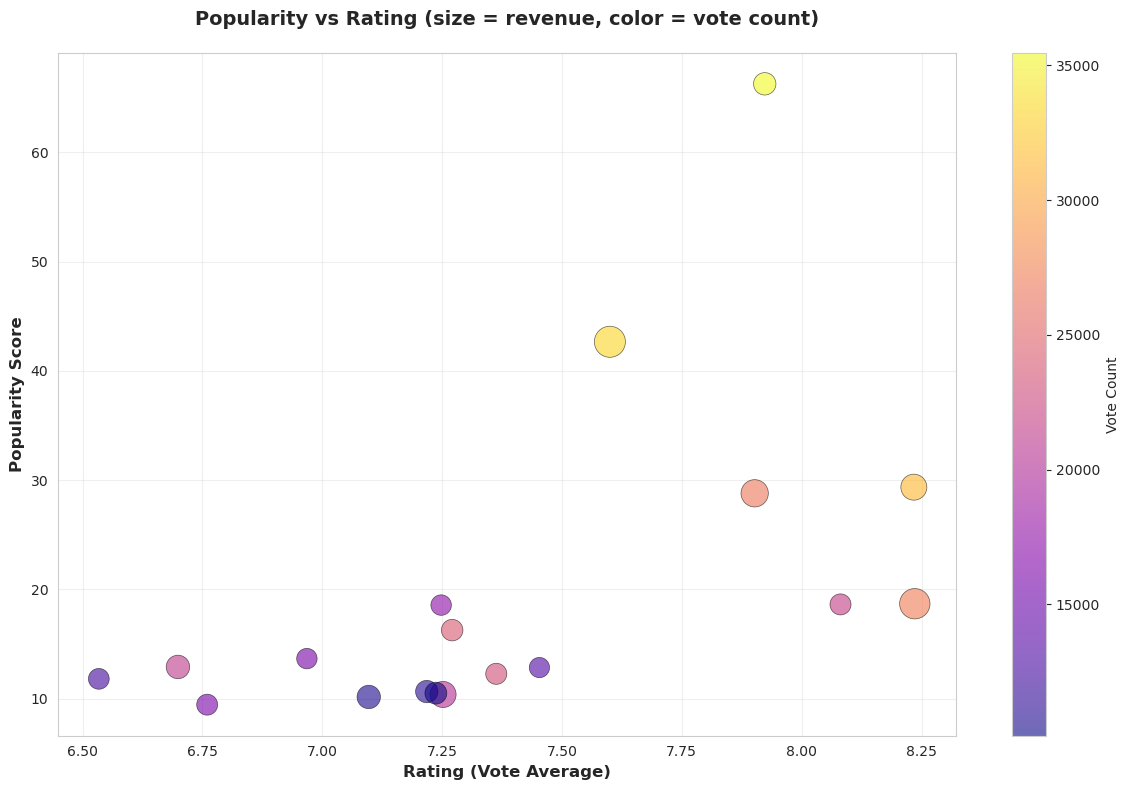


4. Creating Yearly Box Office Trends plot...


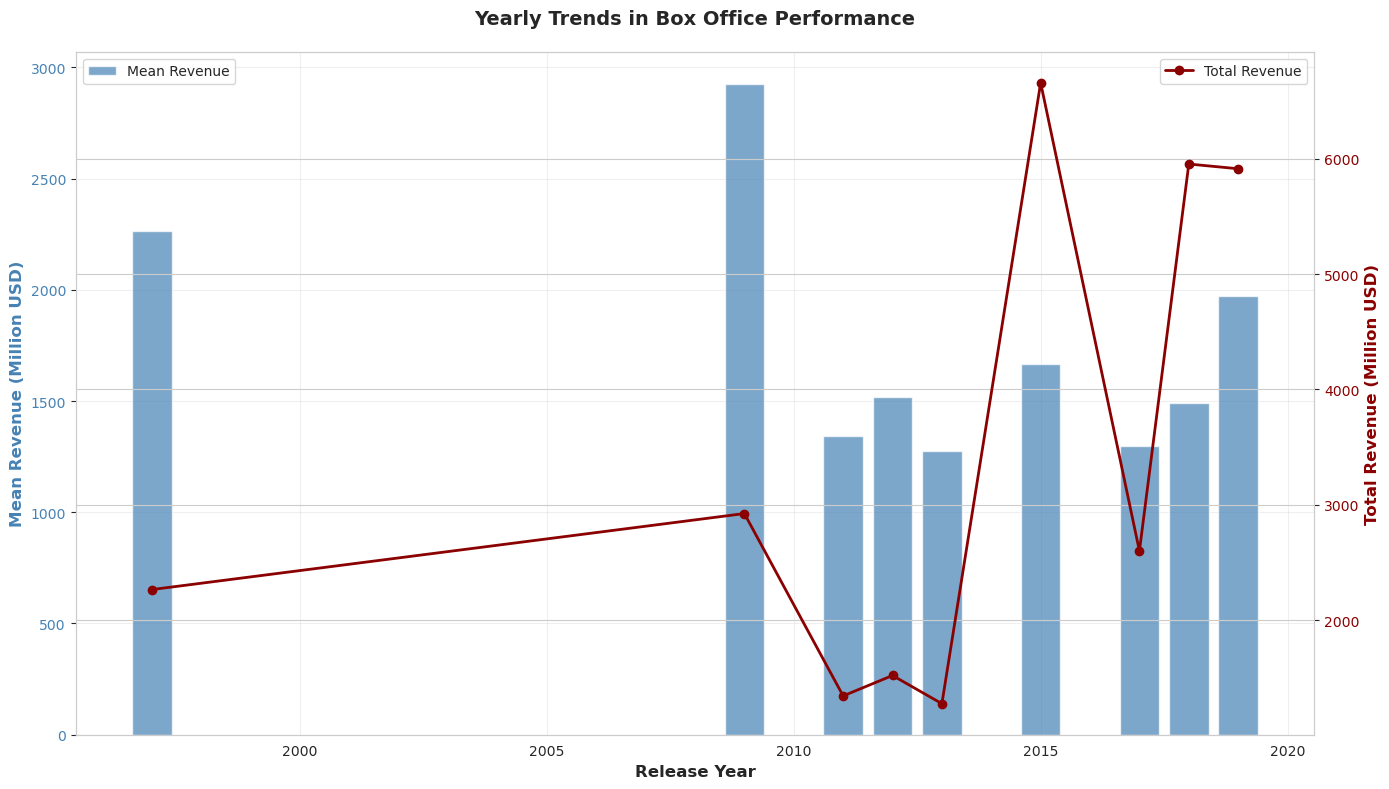


5. Creating Franchise vs Standalone Comparison plot...


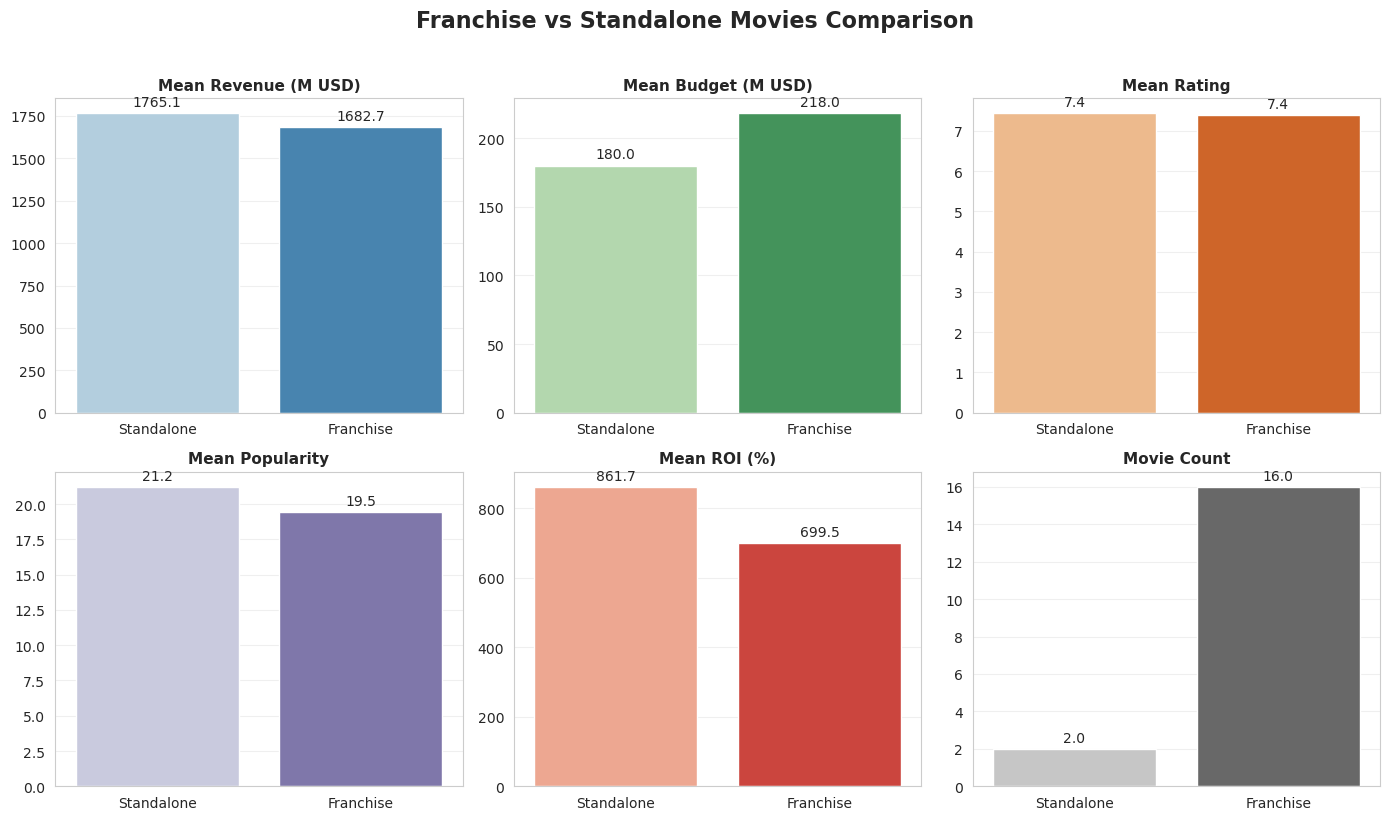


All visualizations created successfully!


In [13]:
import warnings
# Suppress all FutureWarnings and UserWarnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)


from src.viz.visualizations import MovieVisualizer
import matplotlib.pyplot as plt

# Initialize visualizer
viz = MovieVisualizer(spark=spark)

print("="*80)
print("DATA VISUALIZATIONS")
print("="*80)

# 1. Revenue vs Budget Trends
print("\n1. Creating Revenue vs Budget Trends plot...")
fig1 = viz.plot_revenue_vs_budget(cleaned_df, figsize=(12, 8))
plt.show()

# 2. ROI Distribution by Genre
print("\n2. Creating ROI Distribution by Genre plot...")
fig2 = viz.plot_roi_by_genre(cleaned_df, top_n_genres=10, figsize=(14, 8))
plt.show()

# 3. Popularity vs Rating
print("\n3. Creating Popularity vs Rating plot...")
fig3 = viz.plot_popularity_vs_rating(cleaned_df, min_votes=10, figsize=(12, 8))
plt.show()

# 4. Yearly Trends in Box Office Performance
print("\n4. Creating Yearly Box Office Trends plot...")
fig4 = viz.plot_yearly_box_office_trends(cleaned_df, figsize=(14, 8))
plt.show()

# 5. Franchise vs Standalone Comparison
print("\n5. Creating Franchise vs Standalone Comparison plot...")
fig5 = viz.plot_franchise_vs_standalone(cleaned_df, figsize=(14, 8))
plt.show()

print("\n" + "="*80)
print("All visualizations created successfully!")
print("="*80)


## Cleanup

Run this cell when you're done to stop the Spark session.

In [14]:
# Stop SparkSession
stop_spark_session()
print("Spark session stopped")

Spark session stopped
